## 1. Necessary Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
from joblib import dump
from scipy.stats import pearsonr


## 2. Loading & Analyzing Dataset

In [3]:
# Load the dataset
cars_df = pd.read_csv('../data/car_data.csv')

# Display the first few rows of the dataset
cars_df.head()

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
0,Honda,Insight,NaN,7400000.0,2019,1500,Imported,2000,Un-Registered,Automatic
1,Mitsubishi,Minica,Black Minica,1065000.0,2019,660,Imported,68000,Lahore,Automatic
2,Audi,A6,1.8 TFSI Business Class Edition,9300000.0,2015,1800,Local,70000,Lahore,Automatic
3,Toyota,Aqua,G,2375000.0,2014,1500,Imported,99900,Islamabad,Automatic
4,Honda,City,1.3 i-VTEC,2600000.0,2017,1300,Local,55000,Islamabad,Manual


##### Checking detailed information about our dataset

In [473]:
# Check for data types
cars_df.info()
#Checking for number of NULL values
cars_df.isnull().sum()
#describing the dataset
cars_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80572 entries, 0 to 80571
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Make             80572 non-null  object
 1   Model            80572 non-null  object
 2   Version          73800 non-null  object
 3   Price            80572 non-null  object
 4   Make_Year        80572 non-null  int64 
 5   CC               80572 non-null  int64 
 6   Assembly         80572 non-null  object
 7   Mileage          80572 non-null  int64 
 8   Registered City  80572 non-null  object
 9   Transmission     80572 non-null  object
dtypes: int64(3), object(7)
memory usage: 6.1+ MB


,Make_Year,CC,Mileage
count,80572.000000,80572.000000,80572.000000
mean,2011.724209,1404.083267,85653.660080
std,6.953399,684.458171,82241.870901
min,1990.000000,1.000000,1.000000
25%,2007.000000,1000.000000,36500.000000
50%,2013.000000,1300.000000,73000.000000
75%,2017.000000,1600.000000,110520.000000
max,2021.000000,10000.000000,999999.000000


##### We can see that there are cars with less than 600CC engine capacity, we will fix that in the data pre-processing section

In [474]:
cars_df[cars_df['CC']<600].head()

,Make,Model,Version,Price,Make_Year,CC,Assembly,Mileage,Registered City,Transmission
876,Toyota,Vitz,NaN,1950000.0,2011,1,Imported,10000,Lahore,Automatic
1002,Suzuki,Alto,VX,409999.99999999994,1998,100,Imported,31000,Lahore,Manual
1099,Toyota,Prius,NaN,2500000.0,2014,100,Imported,240,Okara,Manual
1143,Suzuki,Vitara,NaN,1590000.0,2018,100,Imported,78000,Islamabad,Manual
1188,Nissan,Dayz,NaN,1820000.0,2016,123,Imported,20000,Karachi,Automatic


##### Some records have price values as 'Call For Price' we will make them NaN and remove the values

In [475]:
# Convert 'Price' column to numeric
cars_df['Price'] = pd.to_numeric(cars_df['Price'], errors='coerce')

#dropping all null values from price column
cars_df.dropna(subset=['Price'], inplace=True)

cars_df['Price'] = cars_df['Price'].astype(float)

##### Visualizing distribution of car prices

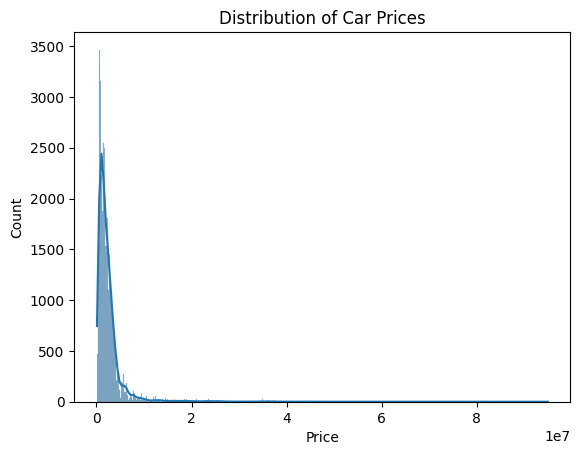

In [476]:
sns.histplot(cars_df['Price'], kde=True)
plt.xlabel('Price')
plt.title('Distribution of Car Prices')
plt.show()


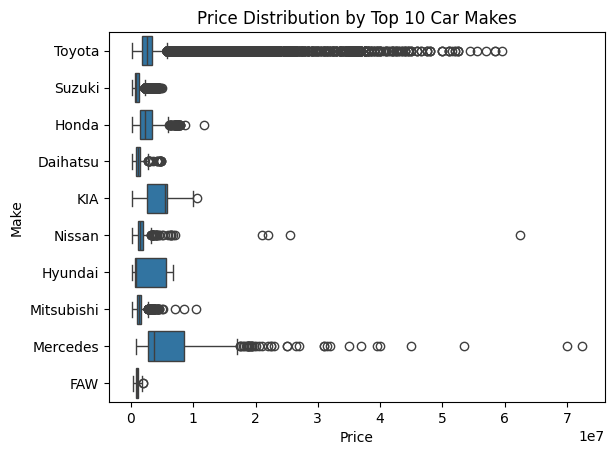

In [477]:
# Select top 10 car makes by frequency
top_makes = cars_df['Make'].value_counts().index[:10]
top_makes_df = cars_df[cars_df['Make'].isin(top_makes)]

sns.boxplot(x='Price', y='Make', data=top_makes_df, order=top_makes)
plt.xlabel('Price')
plt.ylabel('Make')
plt.title('Price Distribution by Top 10 Car Makes')
plt.show()

## 3. Cleaning data

##### Handling abnormal CC values i.e. less than 600 or greater than 5000 by replacing them with a median value

In [478]:
cars_df.loc[(cars_df['CC'] < 600) | (cars_df['CC'] > 5000), 'CC'] = cars_df['CC'].median()

##### For empty version values, we would be filling them with the mode of their respective Make & Models

In [479]:
# filling the version with the mode of each make/model group
def fill_version_with_mode(group):
    mode_version = group['Version'].mode()
    if not mode_version.empty:
        group['Version'].fillna(mode_version[0], inplace=True)
    return group

cars_df = cars_df.groupby(['Make', 'Model']).apply(fill_version_with_mode)

## 4. Feature Engineering

##### Creating a new feature for the age of the car

In [480]:
# Extract age of the car
current_year = datetime.datetime.now().year
cars_df['Vehicle_age'] = current_year - cars_df['Make_Year']
cars_df['Vehicle_age'] = cars_df['Vehicle_age'].round().astype('int64')

# Drop 'Make_Year' column
cars_df.drop(columns=['Make_Year'], inplace=True)

##### Listing categorical and numerical features

In [481]:
# Automatically identify categorical and numerical columns
categorical_features = [col for col in cars_df.columns if cars_df[col].dtype == 'object']
numerical_features = [col for col in cars_df.columns if cars_df[col].dtype in ['int64', 'float64']]

numerical_features.remove('Price')

##### Calculating correlation of each feature with Price and dropping the irrelevant features

In [482]:
corr_df = cars_df
label_encoders = {}
for column in categorical_features:
    le = LabelEncoder()
    corr_df[column] = le.fit_transform(corr_df[column])
    label_encoders[column] = le

correlations = {}
for column in corr_df.drop('Price', axis=1).columns:
    correlation, _ = pearsonr(corr_df[column], y)
    correlations[column] = abs(correlation)

# Sort the correlations by their absolute values in descending order
sorted_correlations = sorted(correlations.items(), key=lambda item: item[1], reverse=True)

# Display the correlations
print('Correlation of each feature with Price')
for column, correlation in sorted_correlations:
    print(f'{column}: {correlation}')


Correlation of each feature with Price
CC: 0.6163768396769429
Transmission: 0.35657121039256373
Vehicle_age: 0.24608696945632724
Assembly: 0.24044970045496222
Registered City: 0.19524634850914896
Mileage: 0.15953956988507134
Version: 0.1534319112449002
Model: 0.09097979320752658
Make: 0.0015903017515283002


In [483]:
cars_df.drop(columns=['Registered City', 'Transmission'], axis=1, inplace=True)
categorical_features.remove('Registered City')
categorical_features.remove('Transmission')

## 4. Data pre-processing

##### Constructing pipelines for numerical and categorical data pre-processing

In [484]:
# Replacing the missing values with mean, and using a standard scaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Replacing the missing values with mode, and using OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


##### Splitting the dataset

In [485]:
# Define the target variable
X = cars_df.drop('Price', axis=1)
y = cars_df['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Model training & evaluations

In [486]:
def trainAndEvaluate(model, X_train, y_train):    
    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'Root Mean Squared Error: {rmse}')
    print(f'R^2 Score: {r2}')
    print(f'Mean Absolute Percentage Error: {mape}')

    return pipeline, y_pred


In [487]:
LRmodel = LinearRegression(n_jobs=-1)
RFmodel = RandomForestRegressor(n_estimators=120,          
                                max_depth=50,
                                max_features= 'sqrt', 
                                min_samples_split=2,        
                                min_samples_leaf=1,
                                n_jobs=-1,        
                                random_state=42)
DTmodel = DecisionTreeRegressor(max_depth=50,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                random_state=42,
                                max_features='sqrt')

##### Training the Linear Regression Model

In [488]:
LRTrained, lrPred = trainAndEvaluate(LRmodel, X_train, y_train)

Root Mean Squared Error: 2561475.9485266027
R^2 Score: 0.5060007020080003
Mean Absolute Percentage Error: 0.32939352353722606


##### Training the Decision Tree Model

In [489]:
DTTrained, dtPred = trainAndEvaluate(DTmodel, X_train, y_train)

Root Mean Squared Error: 1200599.6874749134
R^2 Score: 0.8914718952189066
Mean Absolute Percentage Error: 0.24198880807339274


##### Training the Random Forest Model

In [490]:
RFTrained, rfPred = trainAndEvaluate(RFmodel, X_train, y_train)

Root Mean Squared Error: 802639.0111301887
R^2 Score: 0.9514950238433715
Mean Absolute Percentage Error: 0.19662865117115969


## 6. Best Model & Visualizations

##### As we can see, RandomForestRegressor gave the best results, here are some relevant plots:

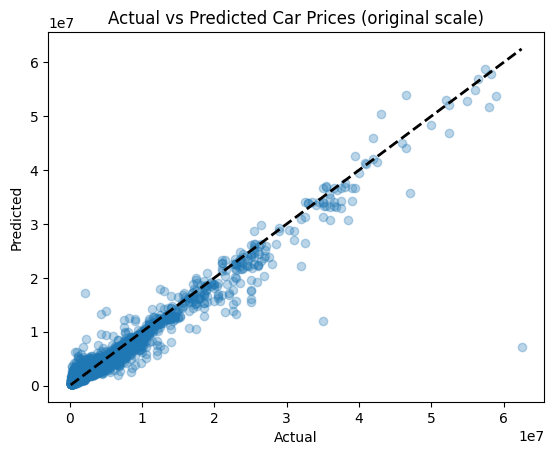

In [491]:
plt.scatter(y_test, rfPred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Car Prices (original scale)')
plt.show()

##### Residual Plot

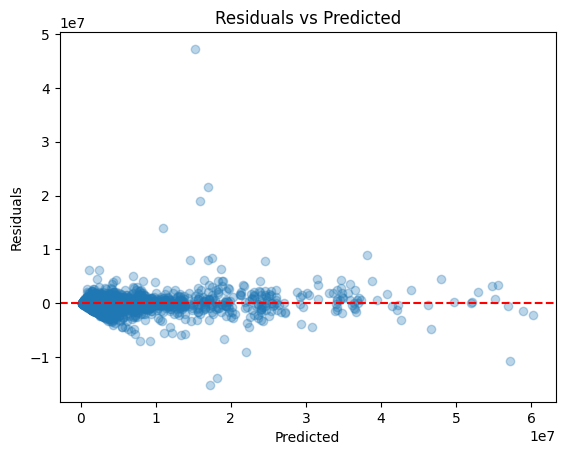

In [492]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


## 7. Exporting Model

In [493]:
#exporting the best model in the working directory
dump(RFTrained, '../saved models/RandomForestModel.pkl')

['RandomForestModel.pkl']